# Designing a Python library for building prototypes around MinHash

This is very much work-in-progress. May be the software and or ideas presented with be the subject of a peer-reviewed or self-published write-up. For now the URL for this is: https://github.com/lgautier/mashing-pumpkins

MinHash in the context of biological sequenced was introduced by the Maryland Bioinformatics Lab [add reference here].

Building a MinHash is akin to taking a sample of all k-mers / n-grams found in a sequence and using that sample as a signature or sketch for that sequence.

## A look at convenience *vs* performance

Moving Python code to C leads to performance improvement... sometimes.

### Test sequence

First we need a test sequence. Generating a random one quickly can be achieved as follows, for example. If you already have you own way to generate a sequence, or your own benchmark sequence, the following code cell can be changed so as to end up with a variable `sequence` that is a `bytes` object containing it.

In [1]:
# we take a DNA sequence as an example, but this is arbitrary and not necessary.
alphabet = b'ATGC'
# create a lookup structure to go from byte to 4-mer
# (a arbitrary byte is a bitpacked 4-mer)
quad = [None,]*(len(alphabet)**4)
i = 0
for b1 in alphabet:
    for b2 in alphabet:
        for b3 in alphabet:
            for b4 in alphabet:
                quad[i] = bytes((b1,b2,b3,b4))
                i += 1
# random bytes for a 1M genome (order of magnitude for a bacterial genome)
import ssl
size = int(1E6)
sequencebitpacked = ssl.RAND_bytes(int(size/4))
sequence = bytearray(int(size))
for i, b in zip(range(0, len(sequence), 4), sequencebitpacked):
    sequence[i:(i+4)] = quad[b]
sequence = bytes(sequence)

### Kicking the tires with `sourmash`

The executable `sourmash` is a nice package from the dib-lab implemented in Python and including a library [add reference here]. Perfect for trying out quick what MinHash sketches can do.

We will create a MinHash of maximum size 1000 (1000 elements) and of k-mer size 21 (all ngrams of length 21 across the input sequences will be considered for inclusion in the MinHash. At the time of writing MinHash is implemented in C/C++ and use that as a reference for speed, as we measure the time it takes to process our 1M reference sequence

In [2]:
from sourmash_lib._minhash import MinHash

import timeit
ntimes = 5

stmt = """
smh = MinHash(1000, 21)
smh.add_sequence(sequence)
"""
t_sourmash = timeit.timeit(stmt,
                           setup='from __main__ import sequence, MinHash; sequence=sequence.decode("utf-8")',
                           number=ntimes)
print("%.2f seconds / sequence" % (t_sourmash/ntimes))

0.30 seconds / sequence


This is awesome. The sketch for a bacteria-sized DNA sequence can be computed very quickly (about a second on my laptop).

### Redisigning it all for convenience and flexibility

We have redesigned what a class could look like, and implemented that design in Python
foremost for our own convenience and to match the claim of convenience. Now how bad is the impact on performance ?

Our new design allows flexibility with respect to the hash function used, and to initially illustrate our point we use `mmh` an existing Python package wrapping MurmurHash3, the hashing function used in `MASH` and `sourmash`.

In [3]:
# make a hashing function to match our design
import mmh3
def hashfun(sequence, nsize, hbuffer, w=100):
    n = min(len(hbuffer), len(sequence)-nsize+1)
    for i in range(n):
        ngram = sequence[i:(i+nsize)]
        hbuffer[i] = mmh3.hash64(ngram)[0]
    return n

from mashingpumpkins.minhashsketch import MaxHashNgramSketch
from array import array
stmt = 'mhs = MaxHashNgramSketch(21, 1000, hashfun); mhs.add(sequence, hashbuffer=array("q", [0, ]*100))'
t_basic = timeit.timeit(stmt,
                        setup='from __main__ import MaxHashNgramSketch, hashfun, sequence, array',
                        number=ntimes)
print("%.2f seconds / sequence" % (t_basic / ntimes))

print("Our Python implementation is %.2f times slower." % (t_basic / t_sourmash))

0.48 seconds / sequence
Our Python implementation is 1.59 times slower.


Ah. Our Python implementation only using `mmh3` and the standard library is not slower.

**note: ** the careful reader will not that we have a MaxHash rather than a MinHash. This is so to use algorithms in the Python stan

There is more to it though. The code in "mashingpumpkins" is doing more by keeping track of the k-mer/n-gram along with the hash value in order to allow the generation of inter-operable sketch [add reference to discussion on GitHub].

We can modifying our class to stop storing the associated k-mer (only keep the hash value) to see if it improves performances:

In [4]:
class NoNgrams(MaxHashNgramSketch):
    
    def _make_elt(self, h, ngram):
        return h
    
    @staticmethod
    def _extracthash(elt):
        return elt

stmt = 'mhs = NoNgrams(21, 1000, hashfun); mhs.add(sequence, hashbuffer=array("q", [0, ]*100))'
t_nongrams = timeit.timeit(stmt,
                           setup='from __main__ import NoNgrams, hashfun, sequence, array',
                           number=ntimes)

print("%.2f seconds / sequence" % (t_nongrams/ntimes))

print("Our Python implementation is %.2f times slower." % (t_nongrams / t_sourmash))

0.49 seconds / sequence
Our Python implementation is 1.63 times slower.


No real difference here. Storing the k-mers / n-grams only has an impact on the added memory required to stored the 1,000
k-mers of length 21.

Our design in computing batches of hash values each time C is reached for MurmurHash3. We have implemented the small C function require to call MurmurHash for several k-mers, and when using it we have interesting performance gains:

In [5]:
from mashingpumpkins._murmurhash3 import hasharray
hashfun = hasharray
stmt = 'mhs = MaxHashNgramSketch(21, 1000, hashfun); mhs.add(sequence)'
t_batch = timeit.timeit(stmt,
                        setup='from __main__ import MaxHashNgramSketch, hashfun, sequence',
                        number=ntimes)

print("%.2f seconds / sequence" % (t_batch/ntimes))

print("Our Python implementation is %.2f times faster." % (t_sourmash / t_batch))


0.11 seconds / sequence
Our Python implementation is 2.83 times faster.


Wow!

At the time of writing this is approximatively 3 times faster than C-implemented `sourmash`. And we are doing more work (we are keeping the ngrams / kmers associated with hash values).

Not keeping the ngrams does not make too much difference:

In [6]:
stmt = 'mhs = NoNgrams(21, 1000, hashfun); mhs.add(sequence)'
t_batch = timeit.timeit(stmt,
                        setup='from __main__ import NoNgrams, hashfun, sequence',
                        number=ntimes)

print("%.2f seconds / sequence" % (t_batch/ntimes))

print("Our Python implementation is %.2f times faster." % (t_sourmash / t_batch))

0.10 seconds / sequence
Our Python implementation is 2.90 times faster.


We also have an alternative fast hashing available (XXHash). Roughly as fast as MurmurHash3.

In [7]:
from mashingpumpkins import _xxhash
hashfun = _xxhash.hasharray
stmt = 'mhs = MaxHashNgramSketch(21, 1000, hashfun); mhs.add(sequence, hashbuffer=array("Q", [0, ]*100))'
t_batch_xxh = timeit.timeit(stmt,
                            setup='from __main__ import MaxHashNgramSketch, hashfun, sequence, array',
                            number=ntimes)

print("%.2f seconds / sequence" % (t_batch_xxh / ntimes))

print("Our Python implementation is %.2f times faster." % (t_sourmash / t_batch_xxh))

0.11 seconds / sequence
Our Python implementation is 2.81 times faster.


## To infinite and beyond

Now how much time should it take to compute signature for various references ?

First we check quickly that the time is roughly proportional to the size of the reference:

In [8]:
def run_sourmash(sketchsize, env, ntimes):
    env['sketchsize'] = sketchsize
    
    stmt = """
smh = MinHash(sketchsize, 21)
smh.add_sequence(sequence)
    """
    setup = """
from __main__ import env, MinHash
sequence=env['sequencen'].decode("utf-8")
sketchsize=env['sketchsize']
    """
    t_sourmash = timeit.timeit(stmt,
                               setup = setup,
                               number=ntimes)

    return {'t': t_sourmash,
            'what': 'sourmash',
            'keepngrams': False,
            'l_sequence': len(env['sequencen']),
            'bufsize': 0,
            'sketchsize': sketchsize}

def run_mashingp(clsname, bufsize, sketchsize, hashfun, env, ntimes):
    buffer = array('Q', [0, ] * bufsize)
    env['buffer'] = buffer
    env['hashfun'] = hashfun
    stmt = """
mhs = %s(21, sketchsize, hashfun)
mhs.add(sequence, hashbuffer=buffer)
""" % clsname
    t_batch = timeit.timeit(stmt,
                            setup='from __main__ import %s, env; '
                                  'sequence=env["sequencen"]; '
                                  'hashfun=env["hashfun"]; '
                                  'buffer=env["buffer"]; '
                                  'sketchsize=env["sketchsize"]' % clsname,
                            number=ntimes)
    if clsname == 'NoNgrams':
        keepngrams = False
    else:
        keepngrams = True
    return {'t': t_batch,
            'what': 'mashingpumpkins',
            'keepngrams': keepngrams,
            'l_sequence': len(env['sequencen']),
            'bufsize': bufsize,
            'sketchsize': sketchsize}

from ipywidgets import FloatProgress
from IPython.display import display
f = FloatProgress(min=0, max=5*8*5*2*2)
display(f)
res = list()
ntimes = 2
for seqsize in (int(1E5), int(3E5), int(5E5), int(1E6), int(5E6)):
    # print('\n* sequence size: {:,}'.format(seqsize))
    env = dict()
    sequencebitpacked = ssl.RAND_bytes(int(seqsize/4))
    sequencen = bytearray(int(seqsize))
    for i, b in zip(range(0, len(sequencen), 4), sequencebitpacked):
        sequencen[i:(i+4)] = quad[b]
    sequencen = bytes(sequencen)
    env['sequencen'] = sequencen
    for sketchsize in (100, 200, 500, 1000, 5000, 10000, 20000, 50000):
        tmp = run_sourmash(sketchsize, env, ntimes)
        tmp.update([('hashfun', 'murmurhash3')])
        res.append(tmp)
        for bufsize in (50, 100, 200, 500, 1000):
            for funname, hashfun in (('murmurhash3', hasharray), ('xxhash', _xxhash.hasharray)):
                for clsname in ('MaxHashNgramSketch', 'NoNgrams'):
                    tmp = run_mashingp(clsname, bufsize, sketchsize, hashfun, env, ntimes)
                    tmp.update([('hashfun', funname)])
                    res.append(tmp)
                    f.value += 1

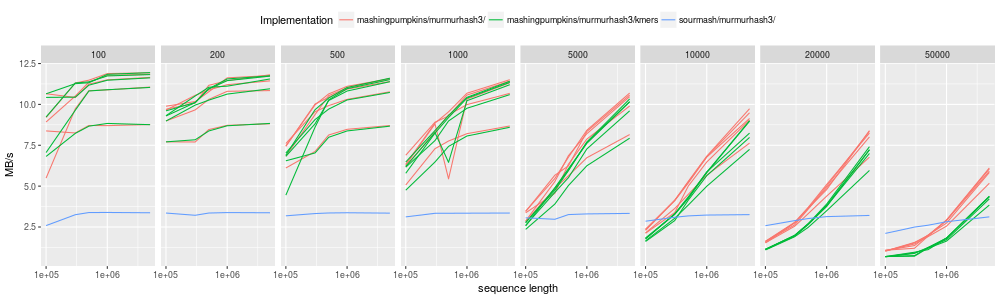

In [26]:
from rpy2.robjects.lib import dplyr, ggplot2 as ggp
from rpy2.robjects.vectors import IntVector, FloatVector, StrVector, BoolVector
from rpy2.robjects import Formula

d = dict((n, FloatVector([x[n] for x in res])) for n in ('t',))
d.update((n, StrVector([x[n] for x in res])) for n in ('what', 'hashfun'))
d.update((n, BoolVector([x[n] for x in res])) for n in ('keepngrams', ))
d.update((n, IntVector([x[n] for x in res])) for n in ('l_sequence', 'bufsize', 'sketchsize'))
dataf = dplyr.DataFrame(d)

p = (ggp.ggplot((dataf
                 .filter("hashfun != 'xxhash'")
                 .mutate(implementation='paste(what, hashfun, ifelse(keepngrams, "kmers", ""), sep="/")'))) +
     ggp.geom_line(ggp.aes_string(x='l_sequence', 
                                  y='l_sequence/(t/%i)/1E6' % ntimes, 
                                  color='implementation',
                                  #lty='bufsize',
                                  #color='keepngrams',
                                  group='paste(implementation, bufsize, keepngrams)'),
                   alpha=1) +
     ggp.facet_grid(Formula('~sketchsize')) +
     ggp.scale_x_log10('sequence length') +
     ggp.scale_y_continuous('MB/s') +
     ggp.scale_color_discrete('Implementation') +
     ggp.theme(legend_position="top"))

import rpy2.ipython.ggplot
rpy2.ipython.ggplot.image_png(p, width=1000, height=300)

The time spent appears proportional to the size of the input sequence within than range of sizes... with the suspicion that our code is scaling better with increasing sequence size (relatively faster as the size is increasing). Larger buffer sizes may make a difference for smaller `max_size` values, and unless dire memory restrictions it appears safer to just have the buffer size set to 250 hash values or more. Keeping the kmers comes with a slight cost for the larger `max_size` values. Our Python implementation is otherwise holding up quite well. XXHash appears give slightly faster processing rates in the best case, and make no difference with MurmushHash3 in other cases (not shown).

One can also observe that the performance dip for the largest `max_size` value is recovering as the input sequence is getting longer. We verifiy this with a .1GB reference and `max_size` equal to 20,000.

In [27]:
seqsize = int(1E8)
print("generating sequence:")
f = FloatProgress(min=0, max=seqsize)
display(f)
sequencebitpacked = ssl.RAND_bytes(int(seqsize/4))
sequencen = bytearray(int(seqsize))
for i, b in zip(range(0, len(sequencen), 4), sequencebitpacked):
    sequencen[i:(i+4)] = quad[b]
    if i % 1000 == 0:
        f.value += 1000
f.value = i+4
sequencen = bytes(sequencen)

generating sequence:


In [32]:
env['sequencen'] = sequencen
sketsize = 20000
bufsize = 1000
funname, hashfun = ('murmurhash3', hasharray)
clsname = 'NoNgrams'
tmp = run_mashingp(clsname, bufsize, sketchsize, hashfun, env, 1)


### Back-of-envelope time

Assuming .2 seconds / bacterial genome, this would allow us to compute the 1,000-kmers signatures for 18,000 bacterial genomes per hour and per CPU. On a laptop (where this notebook was initially run).

In [37]:
print("%.2f seconds" % tmp['t'])
print("%.2f MB / second" % (tmp['l_sequence']/tmp['t']/1E6))

9.61 seconds
10.41 MB / second


Assuming a 3GB proverbial human genome, this would mean a human genome processed in ~ 10 / 1E8 * 3E9 = 300 seconds (5 mins). Not bad.

When considering raw reads from a sequencing run, this would put the 15E9 bases optimally out of a latest
Illumina MiSeq sequencer processed in about 15 minutes. Not great, but quite bearable
when the work can be parallelized (note-to-self: show how to do it) and 4-core machine can be rented per hour on the cloud for cheap... and this is still in Python so customization and ideas can be implemented rather easily and quickly.